<a href="https://colab.research.google.com/github/danielbehargithub/LinkedIn_Salary/blob/main/Salary_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightgbm
!pip install --upgrade lightgbm
!pip install pycountry_convert

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pycountry_convert as pc

import xgboost as xgb
import lightgbm as lgb

# Load the dataset
data = pd.read_csv('salaries.csv')
data = data.drop(columns=["salary", "salary_currency"])

# Identify categorical columns dynamically (excluding the target column)
categorical_columns = [
    'experience_level', 'employment_type', 'employee_residence',
    'company_location', 'company_size', 'job_title', 'remote_ratio'
]

# Convert categorical columns to categorical dtype
for col in categorical_columns:
    data[col] = data[col].astype('category')


# Print the number of unique values for each categorical column
print("\n🔹 Unique value count per categorical column:\n")
for col in categorical_columns:
    unique_count = data[col].nunique()
    print(f"{col}: {unique_count} unique values")



🔹 Unique value count per categorical column:

experience_level: 4 unique values
employment_type: 4 unique values
employee_residence: 94 unique values
company_location: 87 unique values
company_size: 3 unique values
job_title: 298 unique values
remote_ratio: 3 unique values


In [ ]:
# Count the number of records for each job title
job_counts = data['job_title'].value_counts()

# Calculate the percentage of records for each job title
job_percentage = (job_counts / len(data)) * 100



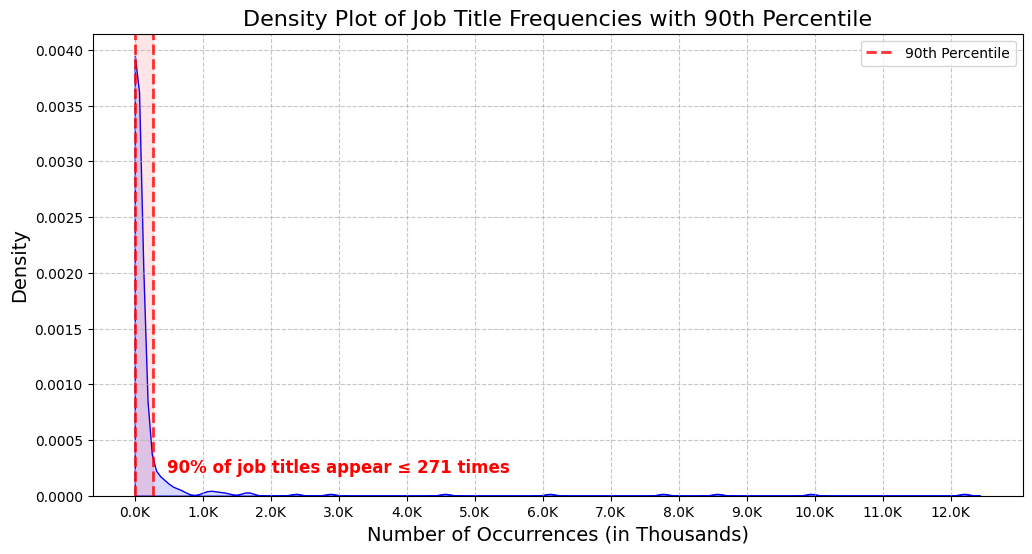

In [ ]:
# Compute the 90th percentile of job title frequencies
percentile_90 = np.percentile(job_counts, 90)

# Create the density plot
plt.figure(figsize=(12, 6))
sns.kdeplot(job_counts, fill=True, color="blue", alpha=0.15, bw_adjust=0.2, clip=(0, None))

# Vertical line to mark the cutoff
plt.axvline(10, color="red", linestyle="--", linewidth=2, alpha=0.8)

# Highlight the area under the 90th percentile
plt.axvspan(0, percentile_90, color="red", alpha=0.1)

# Vertical line marking the 95th percentile
plt.axvline(percentile_90, color="red", linestyle="--", linewidth=2, alpha=0.8, label="90th Percentile")


# Add a text annotation to indicate the 95th percentile threshold
plt.text(percentile_90 + 200, plt.ylim()[1] * 0.05,
         f"90% of job titles appear ≤ {int(percentile_90)} times",
         ha="left", fontsize=12, color="red", weight="bold")

# Titles and labels
plt.title("Density Plot of Job Title Frequencies with 90th Percentile", fontsize=16)
plt.xlabel("Number of Occurrences (in Thousands)", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Improve X-axis ticks resolution
plt.xticks(np.arange(0, job_counts.max() + 500, step=1000),
           labels=[f"{x/1000:.1f}K" for x in np.arange(0, job_counts.max() + 500, step=1000)])

plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


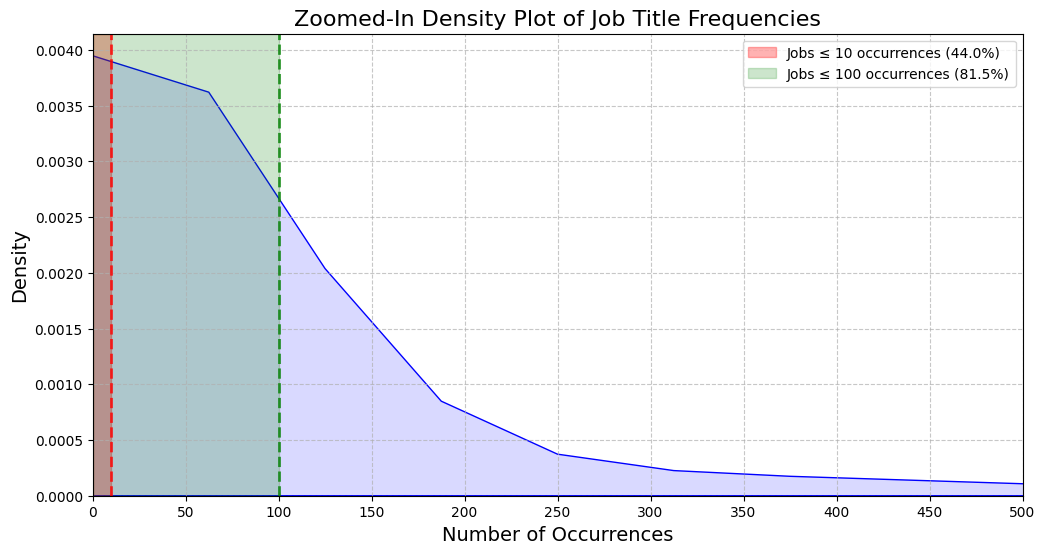

In [ ]:
# Compute percentage of jobs appearing ≤ 100 times
rare_jobs_100 = job_counts[job_counts <= 100].count()
rare_jobs_percentage_100 = (rare_jobs_100 / len(job_counts)) * 100

# Compute percentage of jobs appearing ≤ 10 times
rare_jobs_10 = job_counts[job_counts <= 10].count()
rare_jobs_percentage_10 = (rare_jobs_10 / len(job_counts)) * 100

# Create the density plot
plt.figure(figsize=(12, 6))
sns.kdeplot(job_counts, fill=True, color="blue", alpha=0.15, bw_adjust=0.2, clip=(0, None))

# Highlight area for jobs with ≤ 10 occurrences (in red)
plt.axvspan(0, 10, color="red", alpha=0.3, label=f"Jobs ≤ 10 occurrences ({rare_jobs_percentage_10:.1f}%)")

# Highlight area for jobs with ≤ 100 occurrences (in green)
plt.axvspan(0, 100, color="green", alpha=0.2, label=f"Jobs ≤ 100 occurrences ({rare_jobs_percentage_100:.1f}%)")

# Vertical lines marking the cutoffs
plt.axvline(10, color="red", linestyle="--", linewidth=2, alpha=0.8)
plt.axvline(100, color="green", linestyle="--", linewidth=2, alpha=0.8)

# Titles and labels
plt.title("Zoomed-In Density Plot of Job Title Frequencies", fontsize=16)
plt.xlabel("Number of Occurrences", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Limit the x-axis range to zoom in on job titles ≤ 500 occurrences
plt.xlim(0, 500)

# Improve X-axis ticks resolution
plt.xticks(np.arange(0, 550, step=50), labels=[f"{x}" for x in np.arange(0, 550, step=50)])

plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


Analysis of Job Title Frequency Distribution
The two density plots provide insights into the distribution of job title occurrences in the dataset.

Overall Distribution:

The first plot presents a full view of job title frequencies.
It highlights that 90% of job titles appear fewer than 271 times, emphasizing the dominance of less frequent job titles.

Zoomed-In View (≤ 500 occurrences):

The second plot zooms in on job titles with 500 or fewer occurrences to provide a clearer perspective.
The red region represents job titles that appear ≤ 10 times, showcasing their significant proportion- 44% of all the data
The green region highlights job titles with ≤ 100 occurrences, reinforcing the long-tail nature of the dataset.

This visualization confirms that the majority of job titles have a very low representation in the dataset.

Key Insight: The dataset is highly skewed, with a small number of job titles appearing frequently, while most job titles have very few occurrences. This characteristic should be considered in modeling and feature engineering.



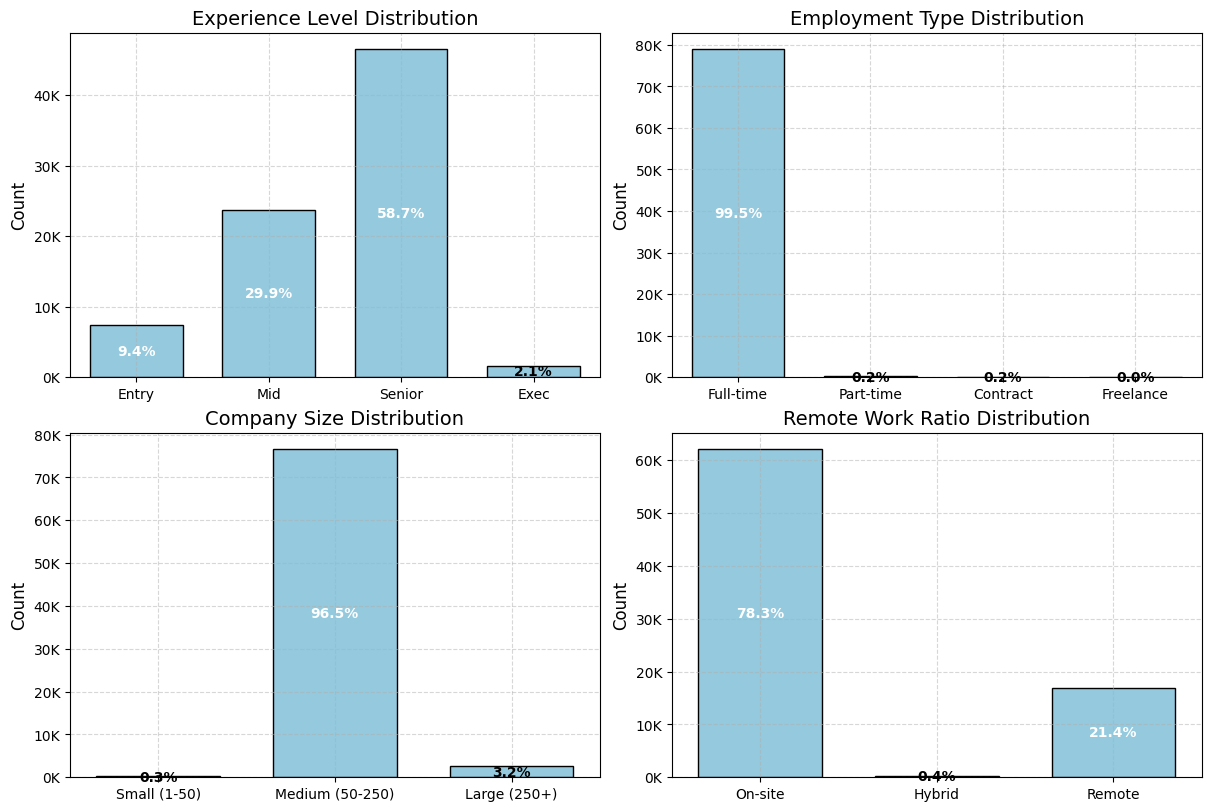

In [ ]:
# Define category explanations
category_explanations = {
    "experience_level": {
        "labels": {"EN": "Entry", "MI": "Mid", "SE": "Senior", "EX": "Exec"},
        "title": "Experience Level Distribution"
    },
    "employment_type": {
        "labels": {"FT": "Full-time", "PT": "Part-time", "CT": "Contract", "FL": "Freelance"},
        "title": "Employment Type Distribution"
    },
    "company_size": {
        "labels": {"S": "Small (1-50)", "M": "Medium (50-250)", "L": "Large (250+)"},
        "title": "Company Size Distribution"
    },
    "remote_ratio": {
        "labels": {0: "On-site", 50: "Hybrid", 100: "Remote"},
        "title": "Remote Work Ratio Distribution"
    }
}

# Create subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
axes = axes.flatten()

# Plot each categorical column
for i, (col, info) in enumerate(category_explanations.items()):
    counts = data[col].value_counts()

    # Ensure correct data type for remote_ratio
    if col == "remote_ratio":
        mapping = {"On-site": 0, "Hybrid": 50, "Remote": 100}
        counts.index = counts.index.map(lambda x: mapping.get(x, x))

    # Reindex to ensure correct order (fill missing values with 0)
    counts = counts.reindex(info["labels"].keys(), fill_value=0)

    # Create bar plot with reduced bar width
    bars = sns.barplot(x=[info["labels"][k] for k in counts.index], y=counts.values, ax=axes[i],
                       color="skyblue", edgecolor="black", width=0.7)

    # Titles and labels
    axes[i].set_title(info["title"], fontsize=14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count", fontsize=12)

    # Format Y-axis in thousands (K)
    axes[i].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x/1000)}K"))

    # Add percentage labels inside bars
    for p, label in zip(axes[i].patches, counts.values):
        height = p.get_height()
        text_color = "white" if height > max(counts.values) * 0.15 else "black"  # White for tall bars

        axes[i].text(p.get_x() + p.get_width() / 2., height / 2,  # Placing in center
                     f'{label / data.shape[0] * 100:.1f}%',
                     ha='center', va='center', fontsize=10, color=text_color, weight="bold")

    # Add dashed grid with lower opacity
    axes[i].grid(True, linestyle="--", alpha=0.5)  # Lighter grid

plt.show()


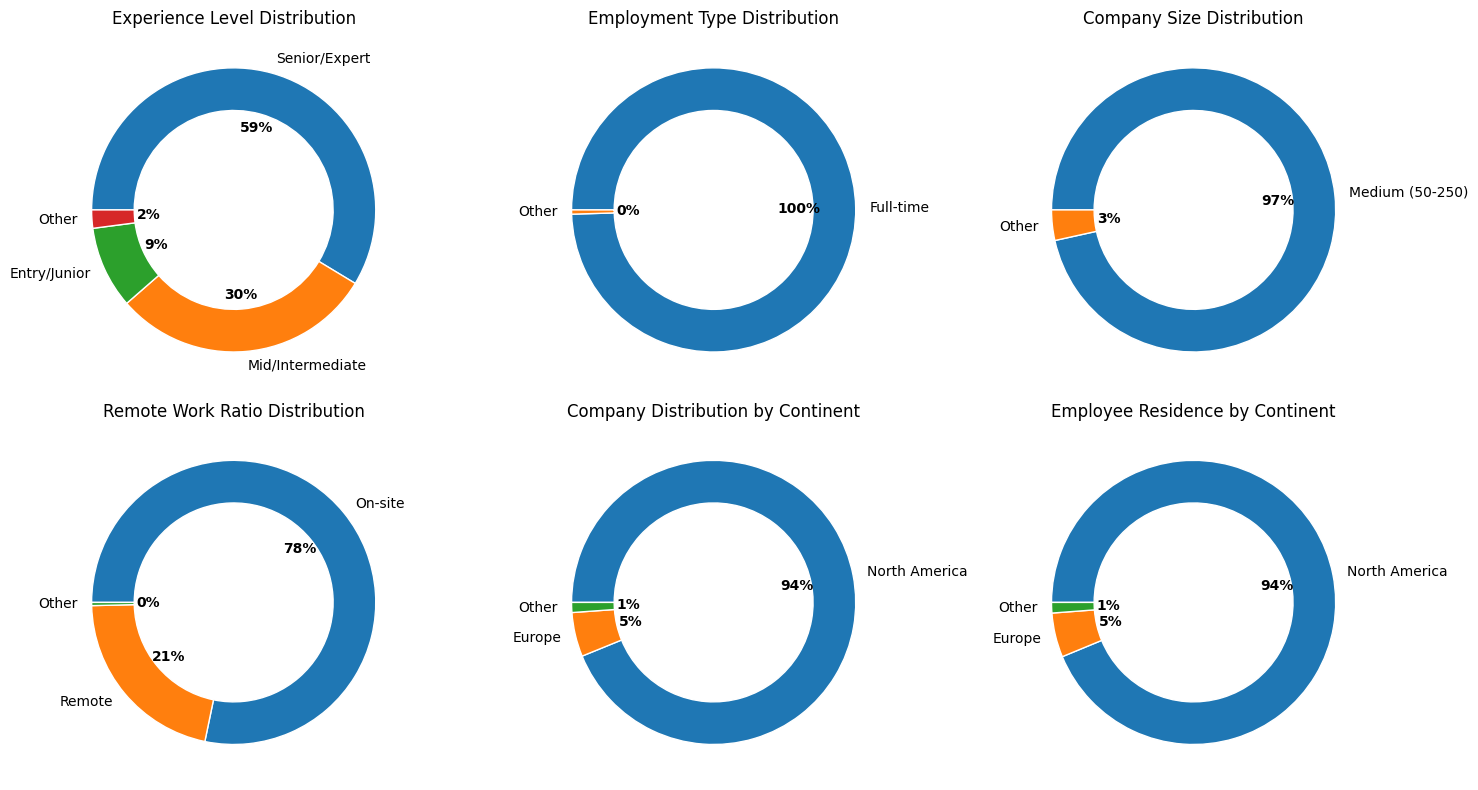

In [ ]:
# Function to convert ISO-2 country code to continent
def country_to_continent(country_code):
    try:
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_names = {
            "NA": "North America",
            "SA": "South America",
            "EU": "Europe",
            "AF": "Africa",
            "AS": "Asia",
            "OC": "Oceania"
        }
        return continent_names.get(continent_code, "Other")
    except:
        return "Other"  # Default if the country code is not recognized

# Compute the continent for each relevant column
data["company_continent"] = data["company_location"].apply(country_to_continent)
data["residence_continent"] = data["employee_residence"].apply(country_to_continent)

# Define category explanations for labeling
category_explanations = {
    "experience_level": {
        "labels": {"EN": "Entry/Junior", "MI": "Mid/Intermediate", "SE": "Senior/Expert", "EX": "Executive/Director"},
        "title": "Experience Level Distribution"
    },
    "employment_type": {
        "labels": {"FT": "Full-time", "PT": "Part-time", "CT": "Contract", "FL": "Freelance"},
        "title": "Employment Type Distribution"
    },
    "company_size": {
        "labels": {"S": "Small (1-50)", "M": "Medium (50-250)", "L": "Large (250+)"},
        "title": "Company Size Distribution"
    },
    "remote_ratio": {
        "labels": {0: "On-site", 50: "Hybrid", 100: "Remote"},
        "title": "Remote Work Ratio Distribution"
    },
    "company_continent": {
        "labels": {},  # Will be automatically filled based on continent data
        "title": "Company Distribution by Continent"
    },
    "residence_continent": {
        "labels": {},  # Will be automatically filled based on continent data
        "title": "Employee Residence by Continent"
    }
}

# Create donut charts for categorical distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # Adjusting to a 2x3 grid
axes = axes.flatten()

for i, (col, info) in enumerate(category_explanations.items()):
    counts = data[col].value_counts().to_dict()
    total = sum(counts.values())

    # Grouping small categories under "Other"
    small_categories = {k: v for k, v in counts.items() if (v / total) * 100 < 5}
    large_categories = {k: v for k, v in counts.items() if (v / total) * 100 >= 5}

    if small_categories:
        small_total = sum(small_categories.values())
        large_categories["Other"] = small_total

    # Creating labels
    labels = [info["labels"].get(k, k) for k in large_categories.keys()]
    values = list(large_categories.values())

    # Generating the donut chart
    wedges, texts, autotexts = axes[i].pie(values, labels=labels, autopct='%1.f%%',
                                           startangle=180, counterclock=False,
                                           wedgeprops=dict(width=0.3, edgecolor="w"))

    for text in autotexts:
        text.set_color("black")
        text.set_fontweight("bold")

    axes[i].set_title(info["title"], fontsize=12)

plt.tight_layout()
plt.show()


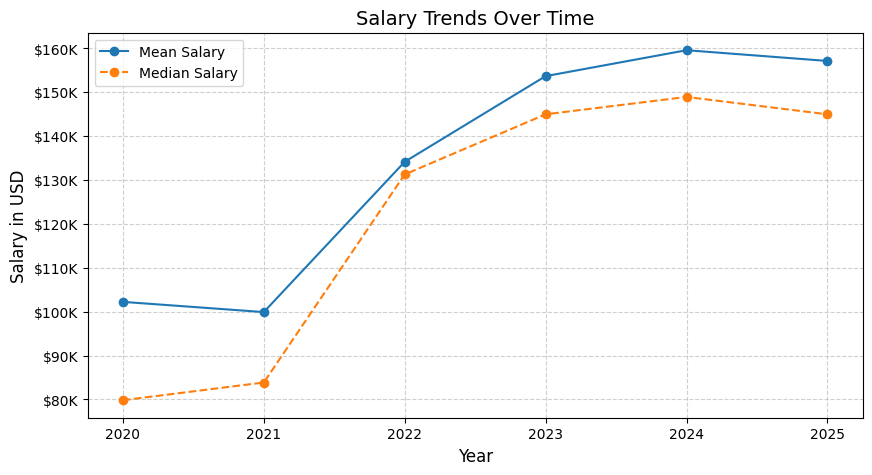

In [ ]:
# Calculate mean and median salary per year
salary_trend = data.groupby("work_year")["salary_in_usd"].agg(["mean", "median"])

plt.figure(figsize=(10, 5))
plt.plot(salary_trend.index, salary_trend["mean"], marker="o", label="Mean Salary")
plt.plot(salary_trend.index, salary_trend["median"], marker="o", label="Median Salary", linestyle="--")

# Title and labels
plt.title("Salary Trends Over Time", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Salary in USD", fontsize=12)

# Format Y-axis to display in thousands (K)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"${x/1000:.0f}K"))

# Grid, legend, and layout improvements
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(salary_trend.index)  # Ensure all years are shown
plt.show()


Demographic and Work Distribution:

The majority of employees fall into the Senior/Expert category (~59%), with Mid-Level roles making up 30%.

Full-time employment is overwhelmingly dominant (100%).

Most companies in the dataset are Medium-sized (50-250 employees), with only a small fraction categorized as "Other."

On-site work remains the primary mode (78%), with only 21% working remotely.

North America dominates both in company locations (94%) and employee residences (94%), with minimal representation from Europe and other regions.

Salary Trends Over Time:

Salaries have increased significantly from 2021 onwards, with a sharp rise in 2022.
The gap between mean and median salaries indicates the presence of high outliers, suggesting that some very high salaries pull the average upwards.

A slight dip in 2025 suggests potential stabilization or a shift in market conditions.

Key Considerations:

Since this dataset is heavily concentrated in North America and includes mostly senior-level, on-site, full-time employees in mid-sized companies, it does not necessarily reflect the broader global job market.

The salary trends observed may be industry-specific and influenced by factors not explicitly represented in the dataset.









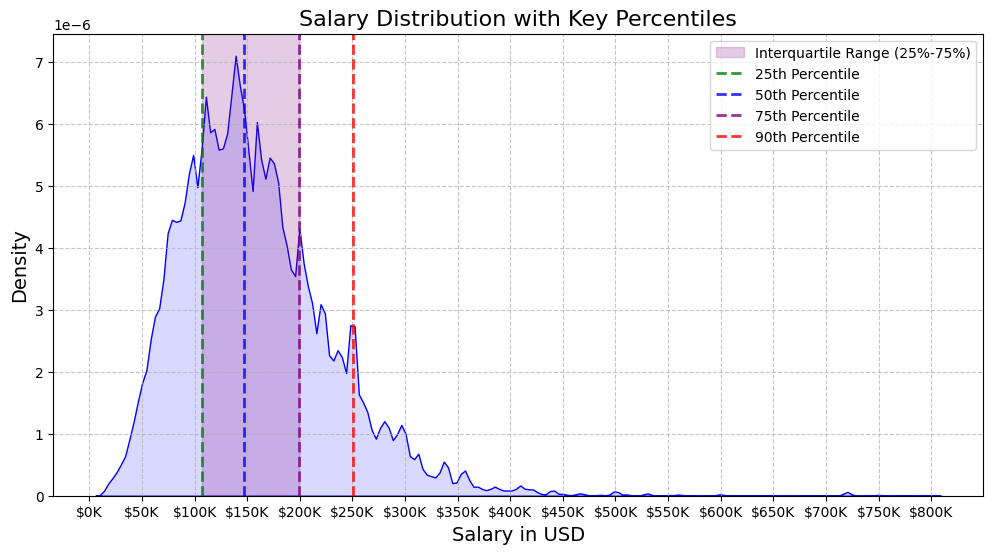

In [ ]:
# Compute salary percentiles (25th, 50th, 75th, 90th)
percentiles = np.percentile(data["salary_in_usd"], [25, 50, 75, 90])
p25, p50, p75, p90 = percentiles
colors = ["green", "blue", "purple", "red"]

# Create KDE density plot
plt.figure(figsize=(12, 6))
sns.kdeplot(data["salary_in_usd"], fill=True, color="blue", alpha=0.15, bw_adjust=0.4, clip=(0, None))

# Highlight the interquartile range (IQR: 25%-75%)
plt.axvspan(p25, p75, color="purple", alpha=0.2, label="Interquartile Range (25%-75%)")

# Add vertical lines for key percentiles
for p, label, color in zip(percentiles, ["25th", "50th", "75th", "90th"], colors):
    plt.axvline(p, color=color, linestyle="--", linewidth=2, alpha=0.8, label=f"{label} Percentile")

# Titles and labels
plt.title("Salary Distribution with Key Percentiles", fontsize=16)
plt.xlabel("Salary in USD", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Format X-axis ticks to display salaries in K (thousands)
plt.xticks(np.arange(0, data["salary_in_usd"].max() + 50000, step=50000),
           labels=[f"${int(x/1000)}K" for x in np.arange(0, data["salary_in_usd"].max() + 50000, step=50000)])

# Add legend and grid lines
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

# Show the plot
plt.show()


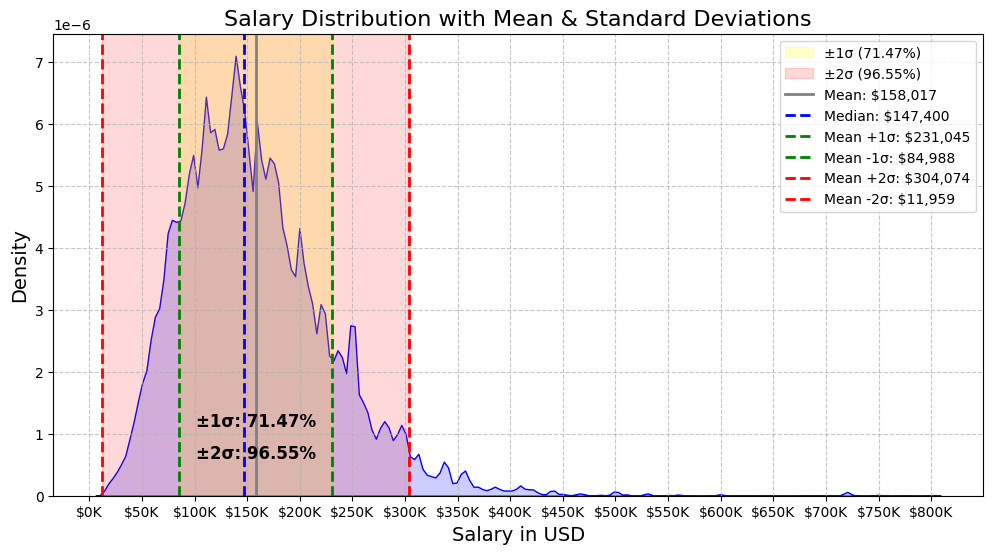

In [ ]:
# Compute statistical values
mean_salary = np.mean(data["salary_in_usd"])
std_salary = np.std(data["salary_in_usd"])
median_salary = np.median(data["salary_in_usd"])

# Compute standard deviation ranges
one_std_above = mean_salary + std_salary
one_std_below = mean_salary - std_salary
two_std_above = mean_salary + 2 * std_salary
two_std_below = mean_salary - 2 * std_salary

# Compute the percentage of data within ±1σ and ±2σ
within_1sigma = ((data["salary_in_usd"] >= one_std_below) & (data["salary_in_usd"] <= one_std_above)).mean() * 100
within_2sigma = ((data["salary_in_usd"] >= two_std_below) & (data["salary_in_usd"] <= two_std_above)).mean() * 100

# Create KDE plot
plt.figure(figsize=(12, 6))
ax = sns.kdeplot(data["salary_in_usd"], fill=True, color="blue", alpha=0.2, bw_adjust=0.4, clip=(0, None))

# Adjust Y-axis label
ax.set_ylabel("Density", fontsize=14)

# Highlight standard deviation ranges
plt.axvspan(one_std_below, one_std_above, color="yellow", alpha=0.2, label=f"±1σ ({within_1sigma:.2f}%)")
plt.axvspan(two_std_below, two_std_above, color="red", alpha=0.15, label=f"±2σ ({within_2sigma:.2f}%)")

# Add key statistical lines
plt.axvline(mean_salary, color="gray", linestyle="-", linewidth=2, label=f"Mean: ${int(mean_salary):,}")  # Lighter mean line
plt.axvline(median_salary, color="blue", linestyle="--", linewidth=2, label=f"Median: ${int(median_salary):,}")
plt.axvline(one_std_above, color="green", linestyle="--", linewidth=2, label=f"Mean +1σ: ${int(one_std_above):,}")
plt.axvline(one_std_below, color="green", linestyle="--", linewidth=2, label=f"Mean -1σ: ${int(one_std_below):,}")
plt.axvline(two_std_above, color="red", linestyle="--", linewidth=2, label=f"Mean +2σ: ${int(two_std_above):,}")
plt.axvline(two_std_below, color="red", linestyle="--", linewidth=2, label=f"Mean -2σ: ${int(two_std_below):,}")

# Add text annotations slightly lower
plt.text(mean_salary, plt.ylim()[1] * 0.15, f"±1σ: {within_1sigma:.2f}%", fontsize=12, color="black", weight="bold", ha='center')
plt.text(mean_salary, plt.ylim()[1] * 0.08, f"±2σ: {within_2sigma:.2f}%", fontsize=12, color="black", weight="bold", ha='center')

# Titles and formatting
plt.title("Salary Distribution with Mean & Standard Deviations", fontsize=16)
plt.xlabel("Salary in USD", fontsize=14)

# Format X-axis labels
plt.xticks(np.arange(0, data["salary_in_usd"].max() + 50000, step=50000),
           labels=[f"${int(x/1000)}K" for x in np.arange(0, data["salary_in_usd"].max() + 50000, step=50000)])

plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


Salary Distribution with Mean & Standard Deviations:

The mean salary is slightly above the median salary,  indicating a right-skewed distribution.

The standard deviation is quite large, and 71.47% of the salaries fall within ±1 standard deviation, while 96.55% fall within ±2 standard deviations.

The wide spread of salaries suggests significant variability in wages across different job titles, experience levels, and company attributes.

Implications:

The long tail in the salary distribution may pose challenges for machine learning models, particularly regression models.

Traditional linear regression might struggle due to the presence of outliers and the non-uniform spread.

Tree-based models (e.g., XGBoost, Random Forest) might require deep trees to capture the full complexity of the distribution, leading to potential overfitting or increased computational costs.

Possible solutions include:

Log transformation of the salary variable to reduce skewness.

Stratified sampling or SMOTE-like techniques to balance representation across salary ranges.

Using quantile regression instead of standard regression.

In [ ]:

X = data.drop(columns=['salary_in_usd'])
y = data['salary_in_usd']



In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Encode categorical variables as numerical values
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_encoded = encoder.fit_transform(X)  # Encode the entire dataset, not just the training set

# Compute Mutual Information on the full dataset
mi_scores = mutual_info_regression(X_encoded, y)

# Create a DataFrame with the results
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by='MI Score', ascending=False)

# Print the top 10 most important features
print(mi_df.head(10))


              Feature  MI Score
3           job_title  0.560384
1    experience_level  0.186524
4  employee_residence  0.182906
6    company_location  0.180511
0           work_year  0.101024
5        remote_ratio  0.085817
7        company_size  0.067100
2     employment_type  0.007111


Key Findings:

job_title (0.560) – The most informative feature for predicting salary. This is expected, as different roles come with vastly different salary ranges.

experience_level (0.187) – Plays a significant role in determining salary, as higher experience generally leads to better compensation.

employee_residence (0.183) – Location of the employee matters, likely due to regional differences in salary expectations, cost of living, or remote work policies.

company_location (0.181) – The country where the company is based affects salaries, possibly due to labor laws, taxes, and economic factors.

work_year (0.101) – Yearly trends have some impact, reflecting salary inflation, industry shifts, or economic cycles.

remote_ratio (0.086) – Remote work flexibility influences salary, though less significantly.

company_size (0.067) – Larger companies may have different pay structures, but its effect is lower than expected.

employment_type (0.007) – Almost negligible impact, meaning full-time, contract, or freelance employment types do not introduce much variance in salaries.


Till now- learned data

Now- try 3 algo: random forest, xgboost, lightgbm

In [ ]:
# חישוב טווח השכר
salary_min = data['salary_in_usd'].min()
salary_max = data['salary_in_usd'].max()
salary_mean = data['salary_in_usd'].mean()

print(f"Minimum Salary: {salary_min:,.2f}")
print(f"Maximum Salary: {salary_max:,.2f}")
print(f"Mean Salary: {salary_mean:,.2f}")
salary_std = data['salary_in_usd'].std()
print(f"Standard Deviation of Salary: {salary_std:,.2f}")


Minimum Salary: 15,000.00
Maximum Salary: 800,000.00
Mean Salary: 158,017.05
Standard Deviation of Salary: 73,029.16


In [ ]:

# הפרדת משתנים תלויים ובלתי תלויים
X = data.drop(columns=['salary_in_usd'])  # הסרת עמודת המטרה
y = data['salary_in_usd']

# חלוקה לנתוני אימון ובדיקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fot rf and xgboost
# One-Hot Encoding למשתנים קטגוריאליים
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)


Naive model

In [ ]:
# חישוב תחזית בסיסית
baseline_prediction = np.mean(y_train)

# חישוב RMSE למודל בסיסי

rmse_baseline = np.sqrt(mean_squared_error(y_test, [baseline_prediction] * len(y_test)))

print(f"Baseline RMSE: {rmse_baseline:,.2f}")


Baseline RMSE: 73,351.77


linear model

In [ ]:
from sklearn.linear_model import LinearRegression
# התאמת מודל רגרסיה ליניארי
lr_model = LinearRegression()
lr_model.fit(X_train_encoded, y_train)

# חיזוי על נתוני הבדיקה
y_pred_lr = lr_model.predict(X_test_encoded)

# הערכת ביצועי המודל
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr= np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
relative_rmse_lr = (rmse_lr / salary_mean) * 100

print(f"Linear Regression - MAE: {mae_lr:,.2f}, RMSE: {rmse_lr:,.2f}")
print(f"Relative RMSE: {relative_rmse_lr:.2f}%")

print(f"Explained Variance (R^2): {r2_lr:.2f}")


Linear Regression - MAE: 45,789.69, RMSE: 61,996.26
Relative RMSE: 39.24%
Explained Variance (R^2): 0.29


random forest:

In [ ]:

# התאמת המודל
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_encoded, y_train)

# חיזוי
y_pred_rf = rf_model.predict(X_test_encoded)

# הערכת ביצועים
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
relative_rmse_rf = (rmse_rf / salary_mean) * 100

print(f"Random Forest - MAE: {mae_rf:,.2f}, RMSE: {rmse_rf:,.2f}")
print(f"Explained Variance (R^2): {r2_rf:.2f}")
print(f"Relative RMSE: {relative_rmse_rf:.2f}%")


Random Forest - MAE: 45,000.94, RMSE: 61,155.39
Explained Variance (R^2): 0.30
Relative RMSE: 38.71%


xgboost

In [ ]:
# התאמת המודל
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_encoded, y_train)

# חיזוי
y_pred_xgb = xgb_model.predict(X_test_encoded)

# הערכת ביצועים
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
relative_rmse_xgb = (rmse_xgb / salary_mean) * 100

print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:,.2f}")
print(f"Explained Variance (R^2): {r2_xgb:.2f}")
print(f"Relative RMSE: {relative_rmse_xgb:.2f}")

XGBoost - MAE: 45008.57, RMSE: 61,182.65
Explained Variance (R^2): 0.30
Relative RMSE: 38.73


In [ ]:
# הגדרת מודל XGBoost עם תמיכה בקטגוריות
xgb_model_categorized = xgb.XGBRegressor(random_state=42, enable_categorical=True)

# אימון המודל
xgb_model_categorized.fit(X_train, y_train)

# חיזוי על נתוני הבדיקה
y_pred_xgb_categorized = xgb_model_categorized.predict(X_test)

# הערכת ביצועים
mae_xgb_categorized = mean_absolute_error(y_test, y_pred_xgb_categorized)
rmse_xgb_categorized = np.sqrt(mean_squared_error(y_test, y_pred_xgb_categorized))
r2_xgb_categorized = r2_score(y_test, y_pred_xgb_categorized)
relative_rmse_xgb_categorized = (rmse_xgb_categorized / salary_mean) * 100

print(f"XGBoost - MAE: {mae_xgb_categorized:.2f}, RMSE: {rmse_xgb_categorized:,.2f}")
print(f"Explained Variance (R^2): {r2_xgb_categorized:.2f}")
print(f"Relative RMSE: {relative_rmse_xgb_categorized:.2f}")

XGBoost - MAE: 45049.51, RMSE: 61,211.58
Explained Variance (R^2): 0.30
Relative RMSE: 38.75


lgb

In [ ]:
# יצירת דאטה ל-LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, categorical_feature=categorical_columns)

# פרמטרים למודל
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 63,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.6,
    'verbose': -1
}

# אימון המודל
lgbm_model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=3),
        ]
)

# חיזוי
y_pred_lgb = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)


mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
# חישוב MSE
mse_lgb = mean_squared_error(y_test, y_pred_lgb)

# חישוב RMSE ידנית
rmse_lgb = np.sqrt(mse_lgb)

r2_lgb = r2_score(y_test, y_pred_lgb)
relative_rmse_lgb = (rmse_lgb / salary_mean) * 100

print(f"LightLGB - MAE: {mae_lgb:,.2f}, RMSE: {rmse_lgb:,.2f}")
print(f"Explained Variance (R^2): {r2_lgb:.2f}")
print(f"Relative RMSE: {relative_rmse_lgb:.2f}")

Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[90]	training's rmse: 60698.4	valid_1's rmse: 59446.7
LightLGB - MAE: 44,795.27, RMSE: 59,446.65
Explained Variance (R^2): 0.32
Relative RMSE: 37.62


Chosen

Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[83]	training's rmse: 60669.5	valid_1's rmse: 59417.1


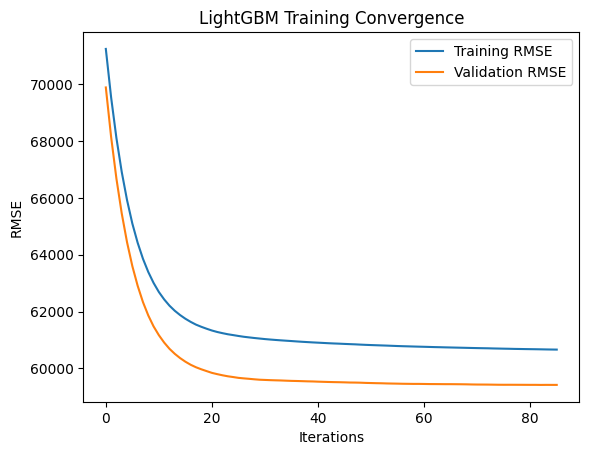

In [ ]:
from lightgbm import LGBMRegressor
from lightgbm import early_stopping

# יצירת מודל LGBMRegressor
LGBMRegressor_model = LGBMRegressor(
    objective='regression',
    metric='rmse',
    learning_rate=0.1,
    num_leaves=63,
    n_estimators=1000
)

# אימון המודל תוך מעקב אחרי סט אימות
LGBMRegressor_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=3)],
)

# הצגת היסטוריית RMSE
plt.plot(LGBMRegressor_model.evals_result_['training']['rmse'], label='Training RMSE')
plt.plot(LGBMRegressor_model.evals_result_['valid_1']['rmse'], label='Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('LightGBM Training Convergence')
plt.legend()
plt.show()


              Feature    Importance
2           job_title  3.269879e+14
0    experience_level  1.204860e+14
3  employee_residence  8.261739e+13
4        remote_ratio  1.244842e+13
5    company_location  1.062676e+13
6        company_size  3.145022e+12
1     employment_type  2.046168e+12


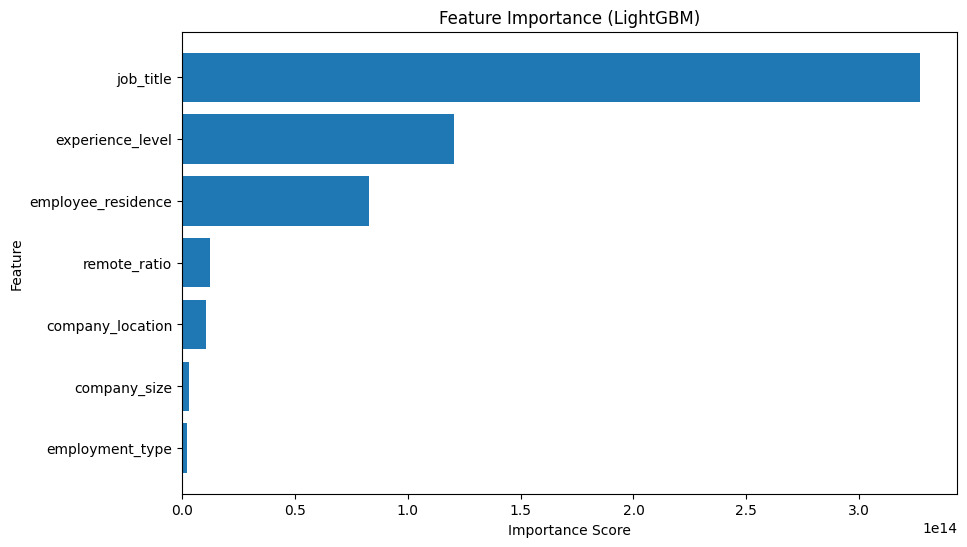

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# קבלת חשיבות הפיצ'רים (אפשר לבחור 'gain' או 'split')
importance = lgbm_model.feature_importance(importance_type='gain')
feature_names = X_train.columns

# יצירת טבלה עם תוצאות
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# הצגת 10 הפיצ'רים הכי חשובים
print(importance_df.head(10))

# ציור גרף החשיבות
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()
plt.show()


              Feature  MI Score
2           job_title  0.447079
7        job_category  0.185401
0    experience_level  0.182259
3  employee_residence  0.158460
5    company_location  0.156215
4        remote_ratio  0.081996
6        company_size  0.066355
1     employment_type  0.008634


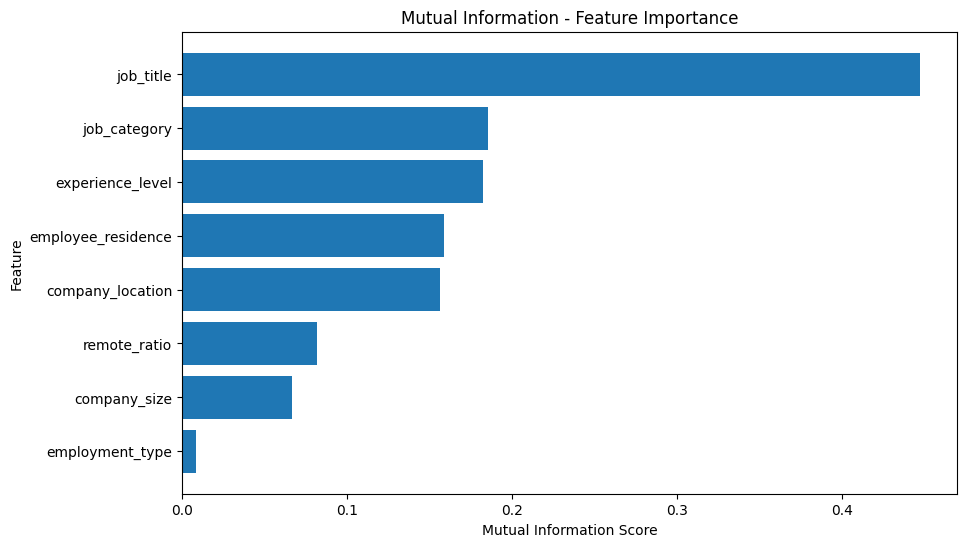

Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[138]	training's rmse: 61100.3	valid_1's rmse: 59718.1


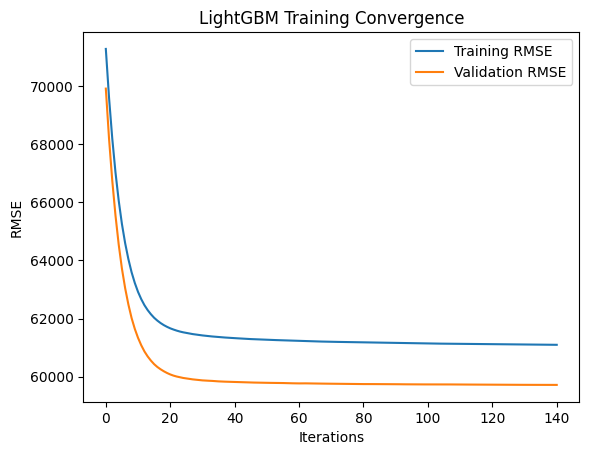

In [ ]:
# נשמור רק את הפיצ'רים שה-MI שלהם גדול מ-0.1
selected_features = mi_df[mi_df["MI Score"] > 0.1]["Feature"].tolist()

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# אימון המודל מחדש

LGBMRegressor_model.fit(
    X_train_selected, y_train,
    eval_set=[(X_train_selected, y_train), (X_test_selected, y_test)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=3)],
)

# הצגת היסטוריית RMSE
plt.plot(LGBMRegressor_model.evals_result_['training']['rmse'], label='Training RMSE')
plt.plot(LGBMRegressor_model.evals_result_['valid_1']['rmse'], label='Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('LightGBM Training Convergence')
plt.legend()
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# חישוב ממוצע, חציון וסטיית תקן של השכר לכל מקצוע
job_salary_stats = data.groupby("job_title")["salary_in_usd"].agg(["mean", "median", "std", "count"])

# עיגול כל הערכים ל-0 ספרות אחרי הנקודה
job_salary_stats = job_salary_stats.round(0)

# מיון לפי סטיית תקן בסדר יורד
job_salary_stats = job_salary_stats.sort_values(by="std", ascending=False)

# הצגת 10 המקצועות עם סטיית התקן הגבוהה ביותר
print(job_salary_stats.head(20))


                                           mean    median       std  count
job_title                                                                 
Finance Data Analyst                   141934.0   61896.0  157972.0      3
Technical Writer                       168049.0  102000.0  150576.0     19
AI Engineering Manager                 179930.0  179930.0  125610.0      2
ML Infrastructure Engineer             229300.0  216800.0  124251.0     18
Head of Machine Learning               288701.0  300000.0  123306.0      9
Cloud Developer                        211500.0  211500.0  118087.0      2
Machine Learning Performance Engineer  262500.0  262500.0  116673.0      2
Prompt Engineer                        190413.0  164492.0  113623.0     49
Enterprise Account Executive           257071.0  180000.0  113484.0     14
Machine Learning Tech Lead             183450.0  183450.0  107692.0      2
Deep Learning Engineer                 190808.0  150000.0  106790.0     12
Data Visualization Engine

<ipython-input-49-3fba189e4177>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  job_salary_stats = data.groupby("job_title")["salary_in_usd"].agg(["mean", "median", "std", "count"])


In [ ]:
import pandas as pd

# חישוב כמות הרשומות לכל תפקיד
job_counts = data["job_title"].value_counts()

# רשימת התפקידים שמופיעים לפחות 300 פעמים
jobs_to_keep = job_counts[job_counts >= 1000].index

# יצירת דאטה מסונן עם .copy() כדי למנוע SettingWithCopyWarning
filtered_df = data[data["job_title"].isin(jobs_to_keep)].copy()

# המרת משתנים קטגוריאליים לסוג category
categorical_features = ["job_title", "experience_level", "employment_type", "company_size", "company_location"]
for col in categorical_features:
    filtered_df[col] = filtered_df[col].astype("category")

# הצגת מספר הרשומות לאחר הסינון
print(f"מספר הרשומות אחרי סינון: {filtered_df.shape[0]}")

from sklearn.model_selection import train_test_split
# זיהוי עמודות טקסטואליות

# בחירת משתנים למודל
X = filtered_df.drop(columns=["salary_in_usd"])  # כל המשתנים חוץ מהשכר
y = filtered_df["salary_in_usd"]  # המשתנה המנובא (שכר)

# פיצול לסט אימון וסט בדיקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# הדפסת גודל הסטים
print(f"Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


מספר הרשומות אחרי סינון: 63584
Train set size: 50867, Test set size: 12717


In [ ]:
# איתור כל העמודות מסוג object (קטגוריאליות)
categorical_features = filtered_df.select_dtypes(include=["object"]).columns.tolist()

# המרת כל העמודות הקטגוריאליות ל-type 'category'
for col in categorical_features:
    filtered_df[col] = filtered_df[col].astype("category")

# הצגת סוג הנתונים לאחר ההמרה
print(filtered_df.dtypes)


experience_level      category
employment_type       category
job_title             category
salary_in_usd            int64
employee_residence    category
remote_ratio          category
company_location      category
company_size          category
job_category          category
dtype: object


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[132]	training's rmse: 61218.7	valid_1's rmse: 62088.6


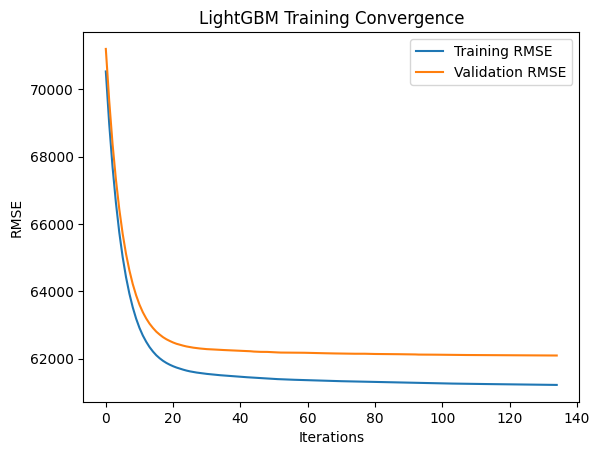

In [ ]:

X = filtered_df.drop(columns=["salary_in_usd"])
y = filtered_df["salary_in_usd"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# יצירת מודל LGBMRegressor
LGBMRegressor_model_2 = LGBMRegressor(
    objective='regression',
    metric='rmse',
    learning_rate=0.1,
    num_leaves=63,
    n_estimators=1000
)

# אימון המודל תוך מעקב אחרי סט אימות
LGBMRegressor_model_2.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=3)],
)

# הצגת היסטוריית RMSE
plt.plot(LGBMRegressor_model_2.evals_result_['training']['rmse'], label='Training RMSE')
plt.plot(LGBMRegressor_model_2.evals_result_['valid_1']['rmse'], label='Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('LightGBM Training Convergence')
plt.legend()
plt.show()


In [ ]:
import numpy as np

# יצירת עותק של הנתונים עם רעש אקראי
X_train_noisy = X_train + np.random.normal(0, X_train.std() * 0.1, X_train.shape)

# אימון מודל על הדאטה עם רעש
model_noisy = LGBMRegressor()
model_noisy.fit(X_train_noisy, y_train)
y_pred_noisy = model_noisy.predict(X_test)

# חישוב R^2 אחרי הוספת רעש
r2_noisy = r2_score(y_test, y_pred_noisy)
print(f"R^2 after adding noise: {r2_noisy:.4f}")


TypeError: 'Categorical' with dtype category does not support reduction 'std'

In [ ]:
model.save_model('lightgbm_model.txt')


In [ ]:
import pandas as pd
from tabulate import tabulate

# יצירת נתוני דוגמה
results = {
    "Model": ["Linear Regression", "Random Forest", "XGBoost", "LightGBM"],
    "MAE": [mae_lr, mae_rf, mae_xgb, mae_lgb],
    "RMSE": [rmse_lr, rmse_rf, rmse_xgb, rmse_lgb],
    "R²": [r2_lr, r2_rf, r2_xgb, r2_lgb],
    "Relative RMSE (%)": [relative_rmse_lr, relative_rmse_rf, relative_rmse_xgb, relative_rmse_lgb],
}

# יצירת DataFrame
results_df = pd.DataFrame(results)

# עיגול הנתונים ל-2 ספרות עשרוניות
df_rounded = results_df.copy()
df_rounded["MAE"] = df_rounded["MAE"].round(2)
df_rounded["RMSE"] = df_rounded["RMSE"].round(2)
df_rounded["R²"] = df_rounded["R²"].round(3)  # ערך קטן יותר, מדויק יותר
df_rounded["Relative RMSE (%)"] = df_rounded["Relative RMSE (%)"].round(2)

# הדפסת הטבלה המעוגלת
print(tabulate(df_rounded, headers="keys", tablefmt="pretty"))


+---+-------------------+----------+----------+-------+-------------------+
|   |       Model       |   MAE    |   RMSE   |  R²   | Relative RMSE (%) |
+---+-------------------+----------+----------+-------+-------------------+
| 0 | Linear Regression | 45789.69 | 61996.26 | 0.286 |       39.24       |
| 1 |   Random Forest   | 45000.94 | 61155.39 | 0.305 |       38.71       |
| 2 |      XGBoost      | 45008.57 | 61182.65 | 0.304 |       38.73       |
| 3 |     LightGBM      | 44907.41 | 61006.69 | 0.308 |       38.62       |
+---+-------------------+----------+----------+-------+-------------------+


In [ ]:
df_rounded.to_csv("model_comparison_results.csv", index=False)


Similar results- now take only jobs with >= 50 entries

In [ ]:

# הפרדת משתנים תלויים ובלתי תלויים
X = filtered_data.drop(columns=['salary_in_usd'])  # הסרת עמודת המטרה
y = filtered_data['salary_in_usd']

# חלוקה לנתוני אימון ובדיקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fot rf and xgboost
# One-Hot Encoding למשתנים קטגוריאליים
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)


In [ ]:

# התאמת המודל
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_encoded, y_train)

# חיזוי
y_pred_rf = rf_model.predict(X_test_encoded)

# הערכת ביצועים
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest - MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")
r2 = r2_score(y_test, y_pred_rf)
print(f"Explained Variance (R^2): {r2:.2f}")


Random Forest - MAE: 42060.22, RMSE: 55424.37
Explained Variance (R^2): 0.23


In [ ]:
# התאמת המודל
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_encoded, y_train)

# חיזוי
y_pred_xgb = xgb_model.predict(X_test_encoded)

# הערכת ביצועים
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")
r2 = r2_score(y_test, y_pred_xgb)


XGBoost - MAE: 41986.65, RMSE: 55327.50
Explained Variance (R^2): 0.24


In [ ]:
# הגדרת מודל XGBoost עם תמיכה בקטגוריות
xgb_model_categorized = xgb.XGBRegressor(random_state=42, enable_categorical=True)

# אימון המודל
xgb_model_categorized.fit(X_train, y_train)

# חיזוי על נתוני הבדיקה
y_pred_xgb = xgb_model_categorized.predict(X_test)

# הערכת ביצועים
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")
r2 = r2_score(y_test, y_pred_xgb)
print(f"Explained Variance (R^2): {r2:.2f}")


XGBoost - MAE: 42332.03, RMSE: 56043.78
Explained Variance (R^2): 0.22


In [ ]:
# יצירת דאטה ל-LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, categorical_feature=categorical_columns)

# פרמטרים למודל
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

# אימון המודל
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=3),
        ]
)

# חיזוי
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# חישוב MSE
mse = mean_squared_error(y_test, y_pred)

# חישוב RMSE ידנית
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
r2 = r2_score(y_test, y_pred)
print(f"Explained Variance (R^2): {r2:.2f}")


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[142]	training's rmse: 54362	valid_1's rmse: 54834.2
Mean Squared Error: 3006787157.72
Root Mean Squared Error: 54834.18
Explained Variance (R^2): 0.25


Relative RMSE: 37.07%


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# יצירת דאטה ל-LightGBM עם free_raw_data=False
train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=categorical_columns,
    free_raw_data=False
)

test_data = lgb.Dataset(
    X_test,
    label=y_test,
    reference=train_data,
    categorical_feature=categorical_columns,
    free_raw_data=False
)

# פונקציה להרצת ניסויים
def run_lgb_experiment(params_list, train_data, test_data, X_test, y_test):
    results = []
    for params in params_list:
        # אימון המודל
        model = lgb.train(
            params,
            train_data,
            valid_sets=[train_data, test_data],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(stopping_rounds=10)]
        )

        # חיזוי
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        # הערכת הביצועים
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # שמירת התוצאה
        results.append({
            'params': params,
            'mse': mse,
            'rmse': rmse,
            'r2': r2
        })

    return results

# רשימת פרמטרים לניסוי
params_list = [
    {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': lr,
        'num_leaves': leaves,
        'min_data_in_leaf': min_data,
        'feature_fraction': feature_frac,
        'bagging_fraction': bagging_frac,
        'verbose': -1
    }
    for lr in [0.01, 0.05, 0.1]  # ניסוי עם Learning Rate משתנה
    for leaves in [15, 31, 63]  # מספר עלים
    for min_data in [20, 50, 100]  # מינימום דוגמאות בכל עלה
    for feature_frac in [0.6, 0.8, 1.0]  # אחוז פיצ'רים
    for bagging_frac in [0.6, 0.8, 1.0]  # אחוז דוגמאות
]

# הרצת הניסוי
results = run_lgb_experiment(params_list, train_data, test_data, X_test, y_test)

# הדפסת התוצאות הטובות ביותר
best_result = min(results, key=lambda x: x['rmse'])
print("Best Parameters:")
print(best_result['params'])
print(f"RMSE: {best_result['rmse']:.2f}, R^2: {best_result['r2']:.2f}")
